In [155]:
import pyvisa
import matplotlib.pyplot as plt
import numpy as np
import srlock
import time

In [156]:
rm = pyvisa.ResourceManager()

rm.list_resources()

('GPIB0::8::INSTR',)

In [24]:
%%time
res = "GPIB0::8::INSTR"

with srlock.SR830(resource=res, timeout=10000) as lia:
    print("IDN:", lia.idn())  # IDN?
    lia.outx(1)  # ensure responses to GPIB
    print("Current phase (deg):", lia.phas())  # PHAS?
    lia.fmod(1)  # internal reference
    print("Freq set, read back:", lia.freq())
    lia.slvl(2.4)
    print(lia.slvl())


IDN: Stanford_Research_Systems,SR830,s/n46821,ver1.07
Current phase (deg): 28.0
Freq set, read back: 78120.0
2.4
CPU times: total: 15.6 ms
Wall time: 181 ms


In [130]:
res = "GPIB0::8::INSTR"
filename_attr = ""
last_filename = ""

# Starting data collection
# freqRange = [5*i + 5 for i in range(1, 100000//5, 10)]
freqRange = [2**i for i in range(3, int(np.log(100_000)/np.log(2)) + 1)]
freqRange.append(100_000)
# voltRange = [i / 10 for i in range(0, 50)]
voltRange = [1e-2]
R0 = 1000

# Data collection
data = np.zeros((len(freqRange), len(voltRange), 4))
noise = np.zeros((len(freqRange), len(voltRange), 4))

# Config
run = 20
timeConst = 1e-2  # in seconds


In [131]:
freq

[0.01]

In [132]:
15*40/60

10.0

In [133]:
%%time
with srlock.SR830(resource=res, timeout=10000) as lia:
    global filename_attr, freqRange, voltRange, data, noise, run, timeConst
    print("IDN:", lia.idn())  # IDN?
    lia.outx(1)  # ensure responses to GPIB
    print("Current phase (deg):", lia.phas())  # PHAS?
    lia.fmod(1)  # internal reference
    print("Freq set, read back:", lia.freq())
    lia.oflt(6)
    # lia.sens(21)
    # lia.aphs()
    # time.sleep(30)
    time.sleep(timeConst)

    for i in range(len(freqRange)):
        for j in range(len(voltRange)):
            print(j)
            try:
                lia.slvl(voltRange[j])
                # if (j == 0):
                #     lia.agan()
                #     time.sleep(30*timeConst)
                lia.freq(freqRange[i])
                # lia.aphs()
                # time.sleep(3*timeConst)
                #lia.agan()
                #time.sleep(3*timeConst)
                print("Frequency:", freqRange[i], "Voltage:", voltRange[j])
                time.sleep(50*timeConst)
                # Poll for values
                runData = np.zeros((run, 4))
                for o in range(run):
                    snap_vals = lia.snap([1, 2, 3, 4])
                    print(snap_vals)
                    runData[o, 0] = snap_vals[0]
                    runData[o, 1] = snap_vals[1]
                    runData[o, 2] = snap_vals[2]
                    runData[o, 3] = snap_vals[3]
                    time.sleep(10*timeConst)
                m = np.mean(runData, axis=0)
                n = np.std(runData, axis=0)
                data[i, j] = m
                noise[i, j] = n
            except Exception as e:
                print(f"{e} DETECTED. SAVING PARTIAL DATA.")
                filename_attr = "incomplete"
                break


# Save data
last_filename = f"noise_data_{time.time():.0f}.npz"
np.savez(last_filename, freqRange=freqRange, voltRange=voltRange, data=data, noise=noise)


IDN: Stanford_Research_Systems,SR830,s/n46821,ver1.07
Current phase (deg): 71.63
Freq set, read back: 4.598
0
Frequency: 8 Voltage: 0.01
[3.00354e-08, -6.56587e-08, 7.19451e-08, -65.274]
[6.72885e-08, -4.47037e-08, 8.05599e-08, -33.462]
[5.79751e-08, -1.51108e-07, 1.61818e-07, -68.898]
[-1.30386e-08, -9.56938e-08, 9.61595e-08, -97.752]
[1.45986e-07, 1.63448e-07, 2.19095e-07, 48.27]
[-2.09549e-08, -1.62051e-07, 1.62982e-07, -97.338]
[6.17006e-08, -1.25497e-07, 1.39466e-07, -63.804]
[-7.12466e-08, 1.09431e-08, 7.17123e-08, 171.06]
[1.59257e-07, -5.65781e-08, 1.68803e-07, -19.524]
[1.0524e-07, 1.88594e-08, 1.07103e-07, 10.212]
[1.09431e-07, 6.44945e-08, 1.27126e-07, 30.528]
[-1.44822e-07, -3.6089e-08, 1.4878e-07, -166.026]
[2.10014e-07, -9.77893e-08, 2.31435e-07, -24.942]
[-9.3133e-10, 1.49478e-07, 1.49478e-07, 90.318]
[-2.51458e-08, 6.98495e-10, 2.51458e-08, 178.104]
[-6.28647e-08, -6.70557e-08, 9.17357e-08, -133.308]
[6.33304e-08, -1.28291e-07, 1.42959e-07, -63.702]
[-2.16534e-08, 2.165

In [134]:
data.shape

(15, 1, 4)

In [142]:
# loaded_data = np.load(last_filename)
loaded_data = np.load("data_1762427561.npz")
# data_1762427561.npz

In [150]:
X = loaded_data["data"][:, :, 0]
Y = loaded_data["data"][:, :, 1]
R = loaded_data["data"][:, :, 2]
Theta = loaded_data["data"][:, :, 3]
freqRange_coll = loaded_data["freqRange"][:]
noise_coll = loaded_data["noise"]
Resistance = 1e3 * R0 * R / 1.5
ResistanceX = 1e3 * R0 * X / 1.5

In [151]:
X

array([[ 7.241991e-06],
       [ 4.068050e-06],
       [ 2.513095e-06],
       [ 1.735245e-06],
       [ 1.408170e-06],
       [ 1.323230e-06],
       [ 1.543025e-06],
       [ 2.145780e-06],
       [ 3.469006e-06],
       [ 6.519290e-06],
       [ 1.912580e-05],
       [-4.470370e-08],
       [ 1.487890e-05],
       [ 3.324994e-05],
       [ 5.123040e-05]])

In [152]:
noiseX = loaded_data["noise"][:, :, 0].flatten()
noiseR = loaded_data["noise"][:, :, 2].flatten()
noiseY = loaded_data["noise"][:, :, 1].flatten()
noiseTheta = loaded_data["noise"][:, :, 3].flatten()

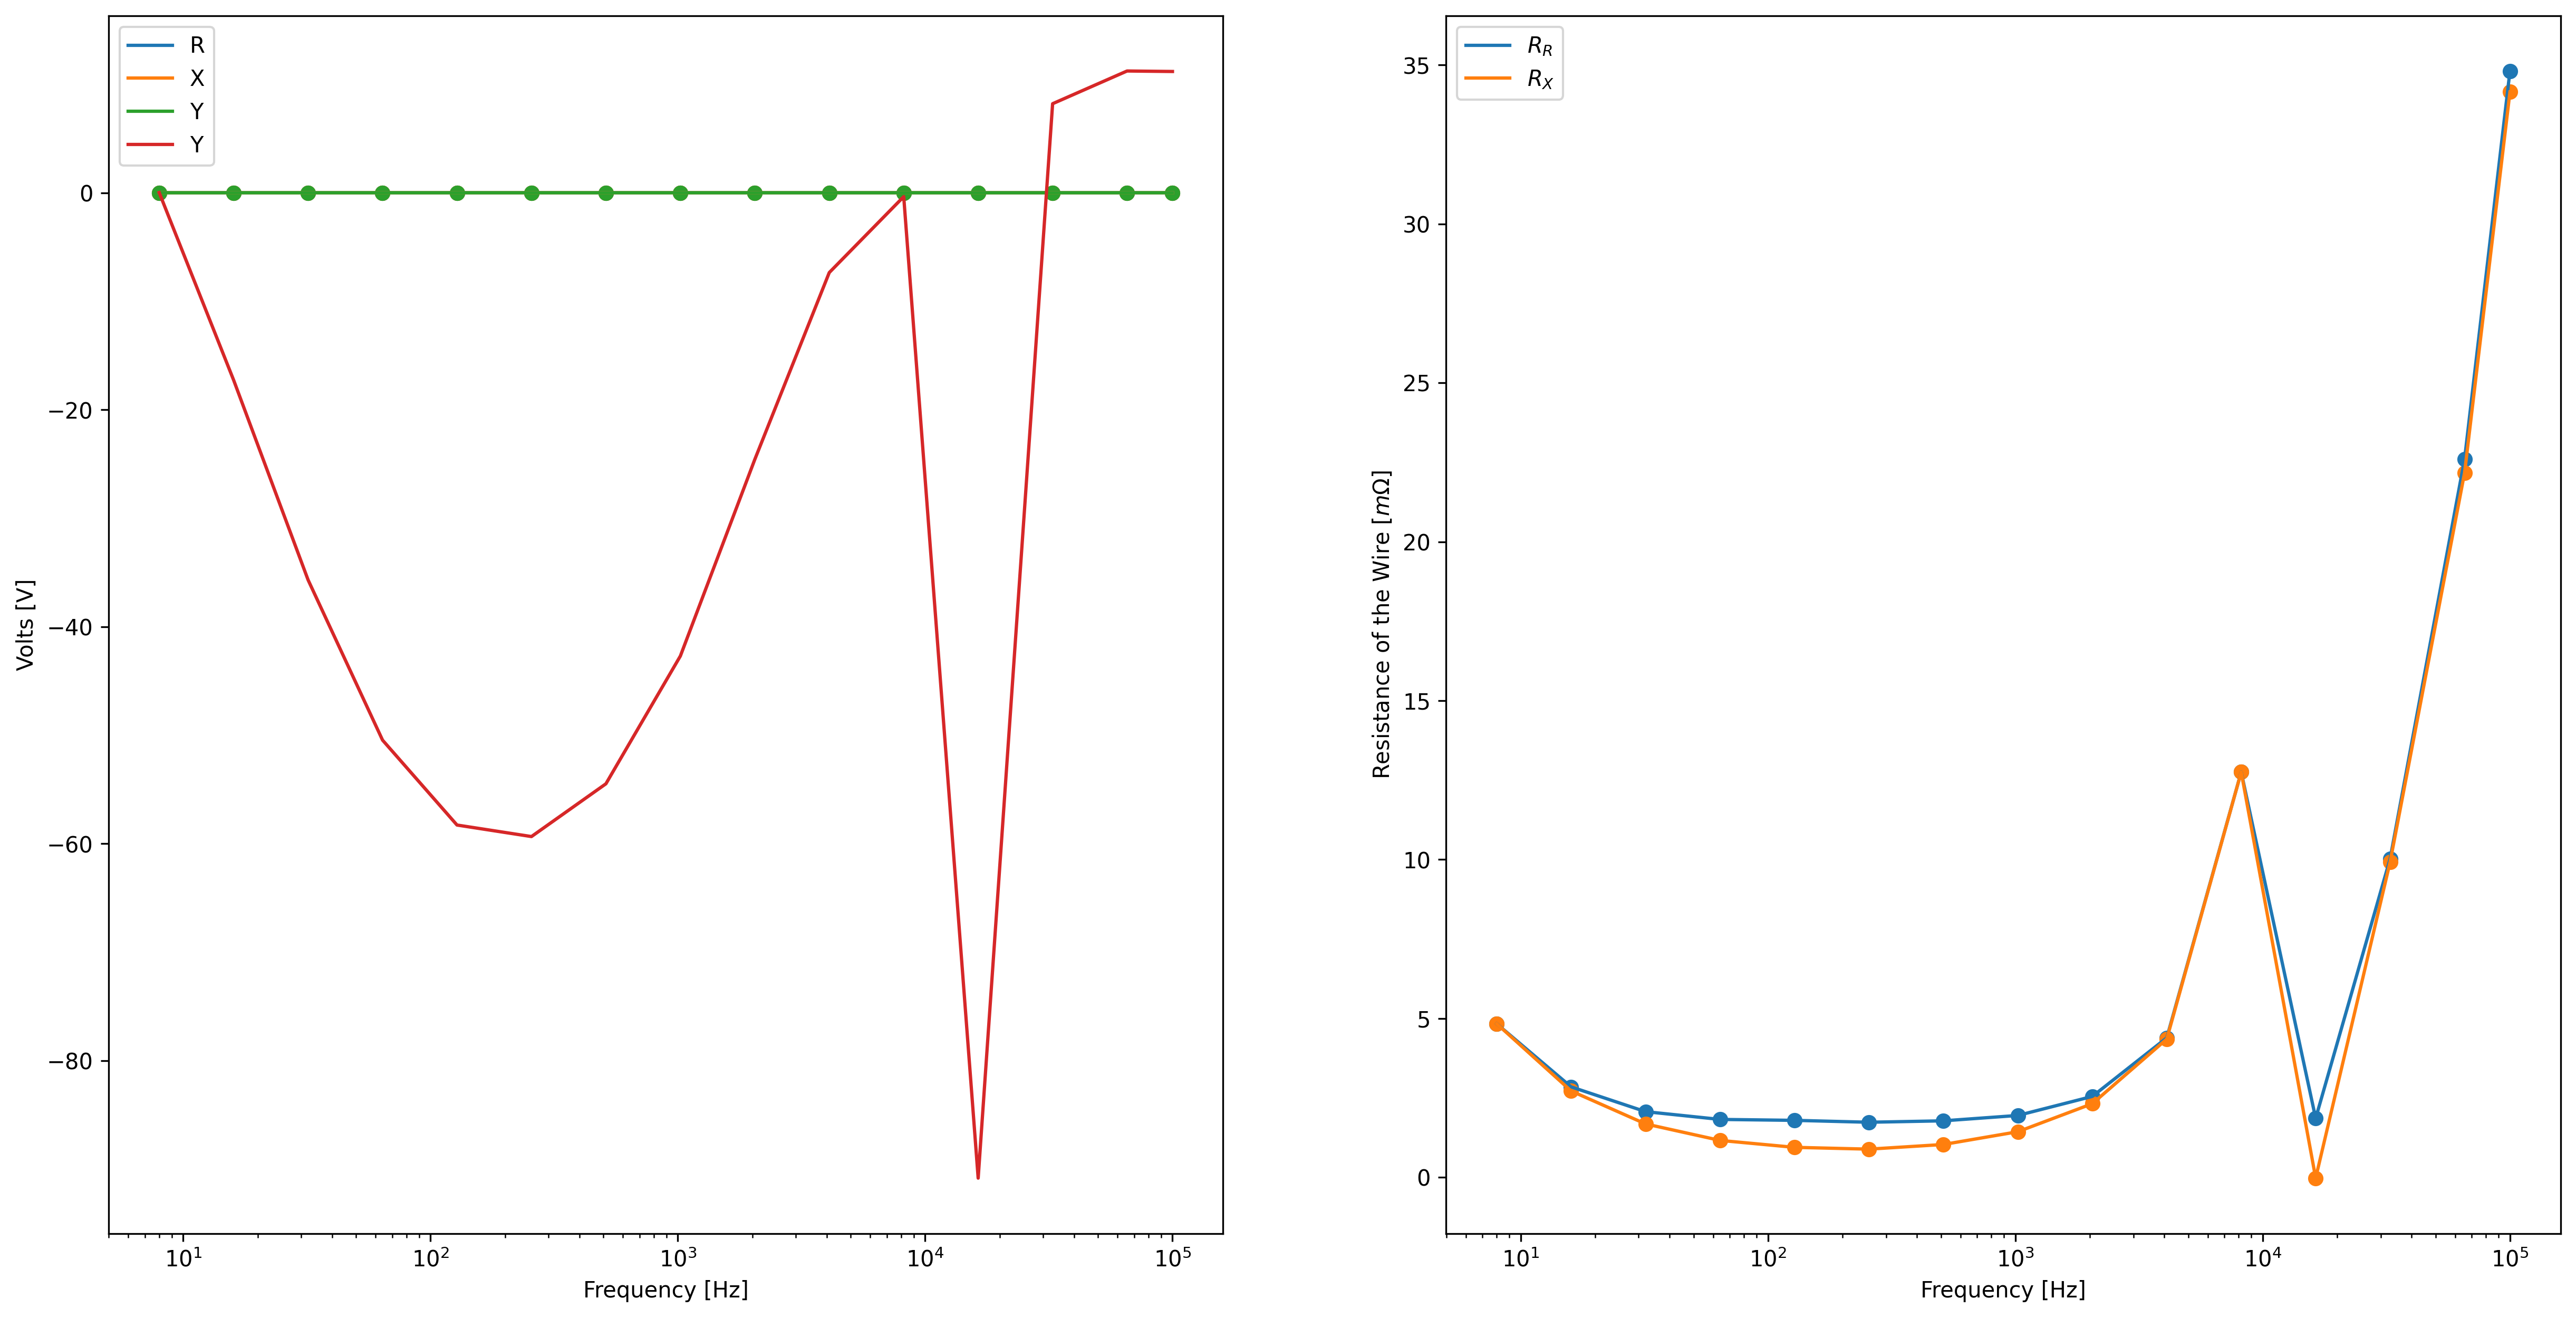

In [153]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(20,10))
ax = axes[0]
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Volts [V]")
ax.set_xscale("log")
ax.scatter(freqRange_coll, R)
ax.scatter(freqRange_coll, X)
ax.scatter(freqRange_coll, Y)
ax.plot(freqRange_coll, R, label="R")
ax.plot(freqRange_coll, X, label="X")
ax.plot(freqRange_coll, Y, label="Y")
ax.plot(freqRange_coll, Theta, label="Y")
# ax.errorbar(freqRange_coll, R, yerr=noiseR)
ax.legend()
ax = axes[1]
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Resistance of the Wire [$m\Omega$]")
ax.plot(freqRange_coll, Resistance, label="$R_R$")
ax.plot(freqRange_coll, ResistanceX, label="$R_X$")
ax.scatter(freqRange_coll, Resistance)
ax.scatter(freqRange_coll, ResistanceX)
ax.set_xscale("log")
ax.legend()
# fig.savefig("Res_vs_freq.png", dpi=300)

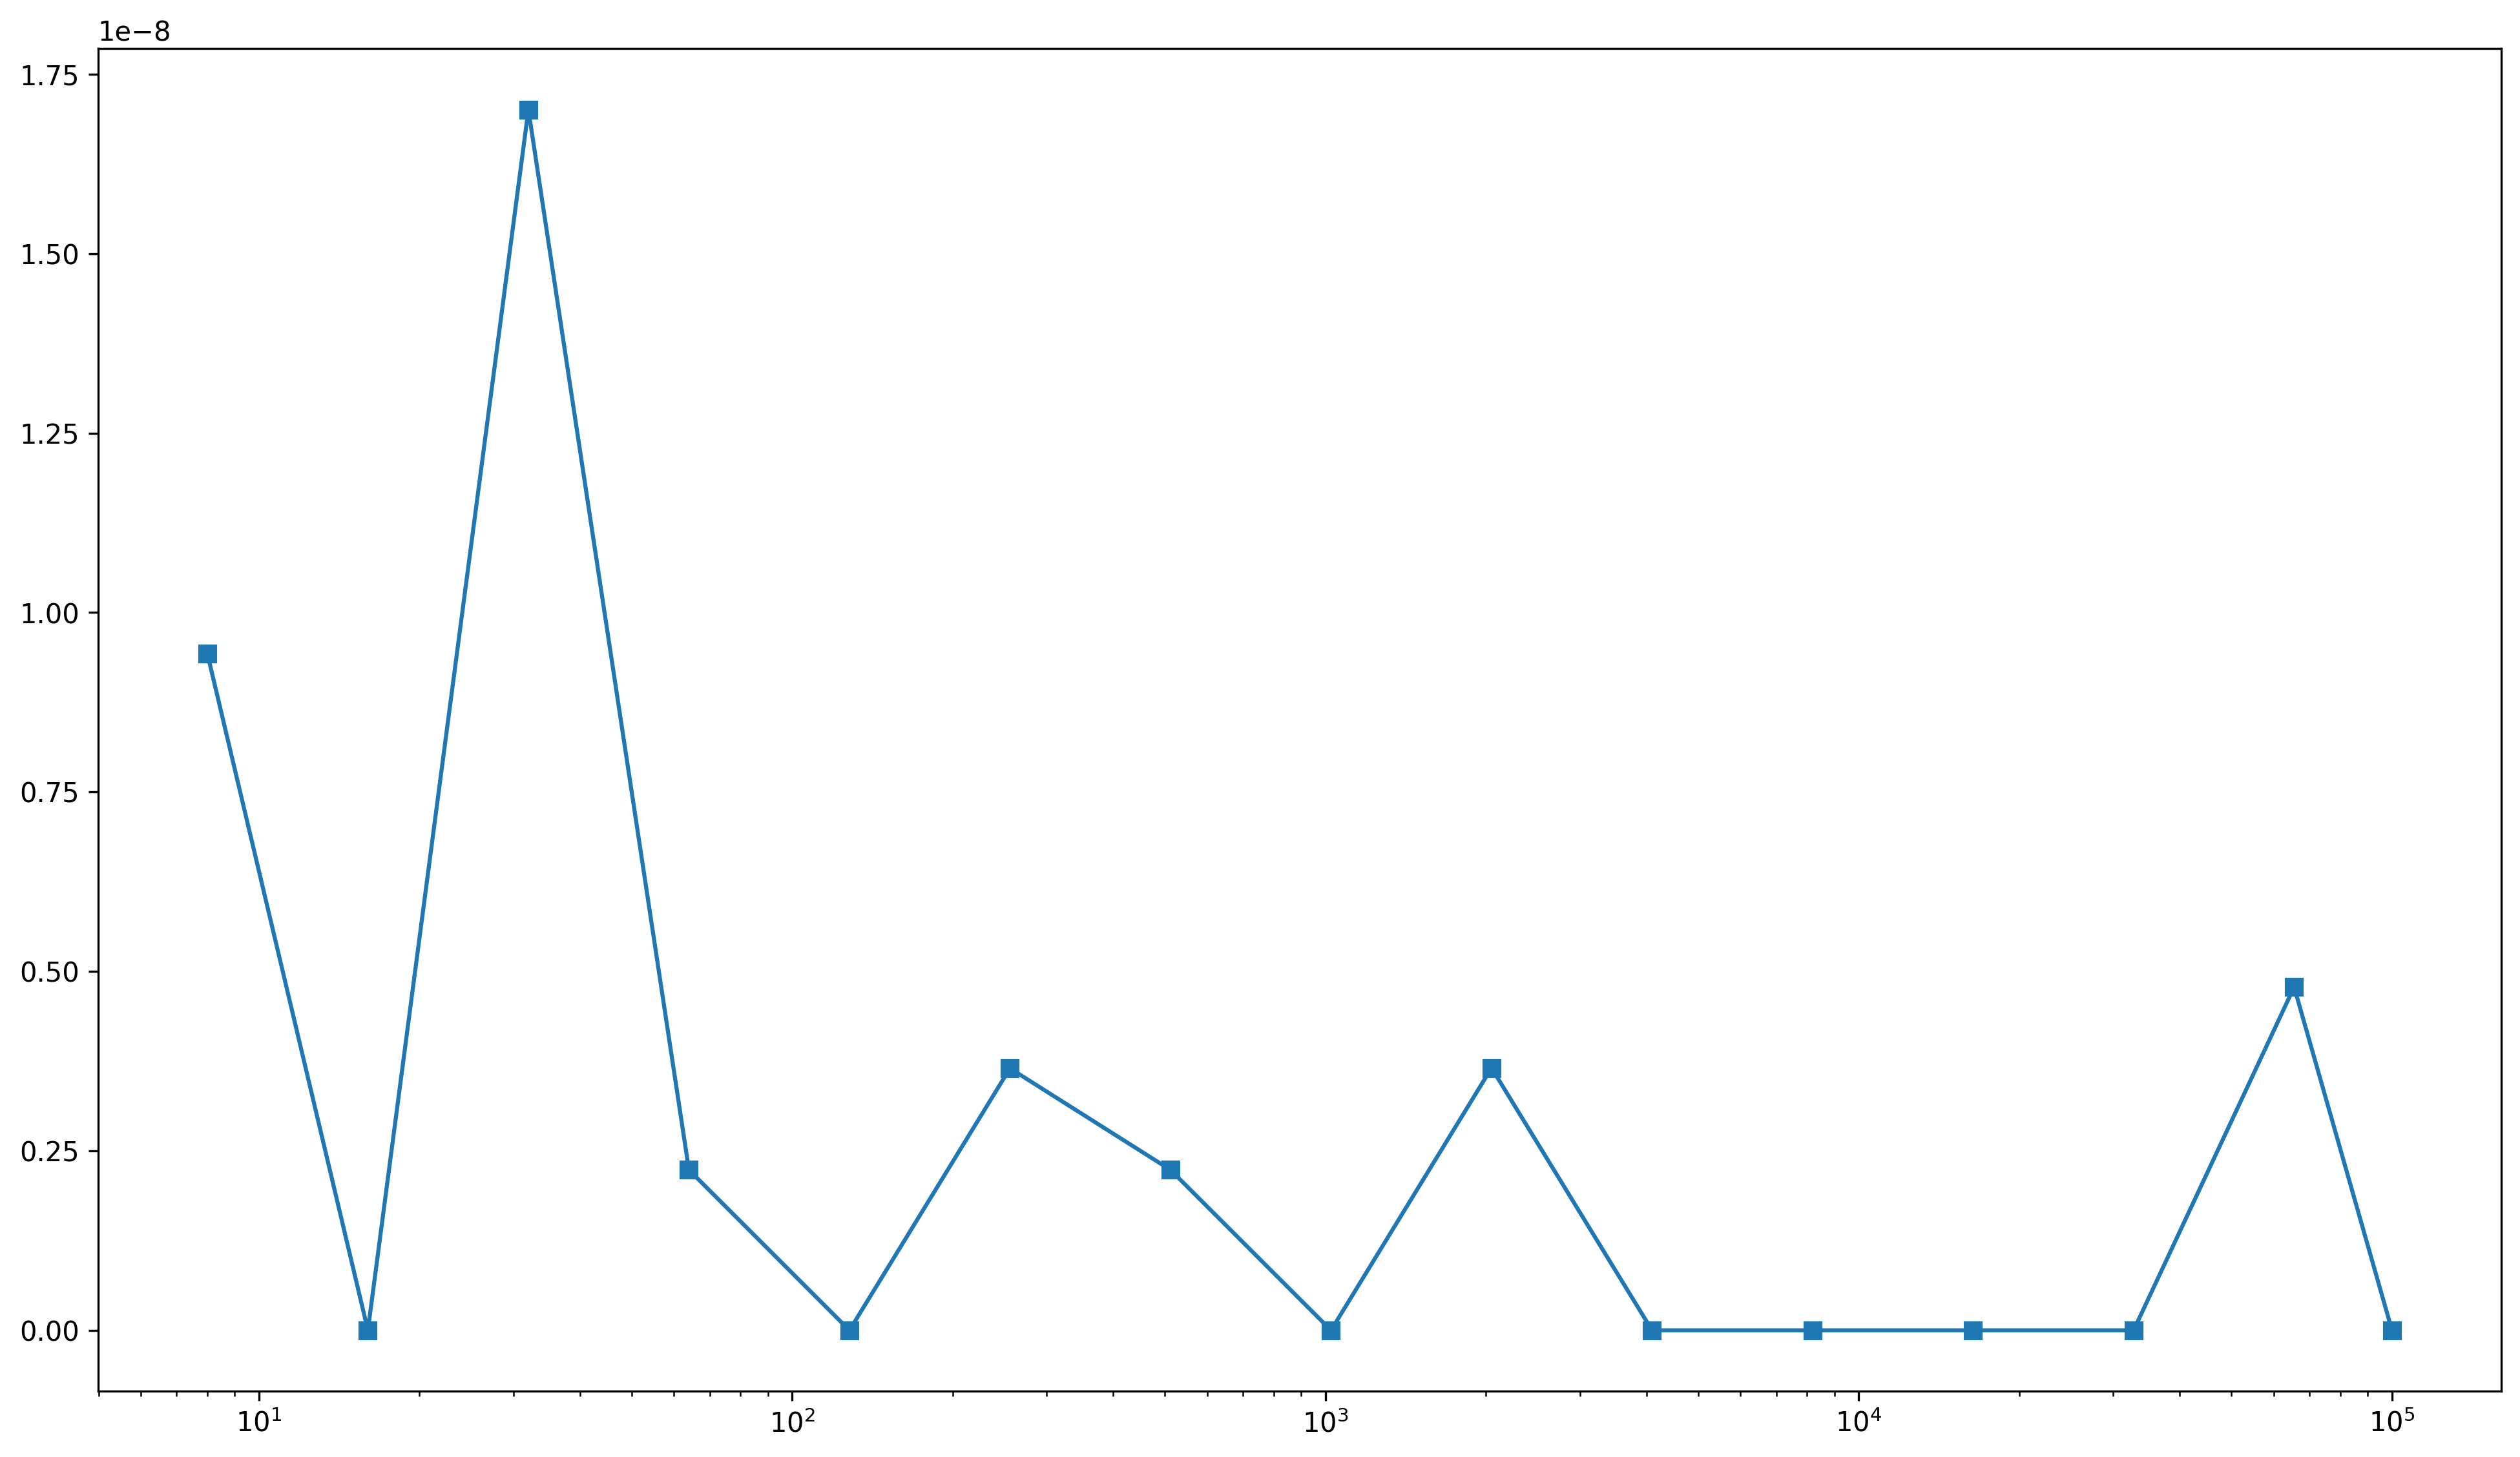

In [154]:
fig, axes = plt.subplots(1,1, dpi =300, figsize = (16,9))
axes.set_xscale("log")
# axes.set_yscale("log")
yval = 1/freqRange_coll
axes.plot(freqRange_coll, noiseX, marker = "s")
# axes.plot(freqRange_coll, yval)